In [2]:
## Preamble / required packages
import numpy as np
np.random.seed(0)

## Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
from IPython.display import Image, display
%matplotlib inline

import warnings
## Comment this out to activate warnings
warnings.filterwarnings('ignore')


plt.style.use("dark_background")

## More advanced neural network types

+ Recall that a neural network is any trainable function that maps a vector to a vector
+ In the previous notebook, we saw how to train a multilayer perceptron (MLP)

For example, a two-layer MLP:
$$
\hat{\mathbf{y}} = \sigma(\boldsymbol{\theta}_2 \sigma(\boldsymbol{\theta}_1 \mathbf{x}))
$$

We can also write a recurrence relation for the $i$-th hidden layer

$$
\mathbf{h}_i = \sigma(\boldsymbol{\theta}_i \mathbf{h}_{i-1}) \quad \text{for } i = 1, \ldots, L
$$
where $\mathbf{h}_0 = \mathbf{x}$ and $\mathbf{h}_{L+1} = \hat{\mathbf{y}}$


### More elaborate architectures and structures exist
+ Convolutional neural networks (trainable convolutional kernels)
+ Recurrent neural networks (trainable transition matrices for sequential data)
+ Residual networks (matrix multiplications with "skip" connections for easier gradient-based training)
+ Autoencoders (unsupervised representation learning)
+ Generative models (GANs, VAEs, diffusion models, etc.)
+ Neural ODEs (trainable ODEs)
+ Transformers (attention-based architectures)

# Physical symmetries as a prior on model space

+ When working with physical data, we often are aware of certain constraints that a model of a process must obey
+ A model that classifies an ergodic dynamical system should be invariant to time translation
+ A model that classifies images of a crystal should be invariant to shifts along lattice symmetries
+ A model that classifies a fluid flow should be invariant to spatial translations


### A few options

+ Ignore our knowledge, and obtain enough data that the model can learn the underlying symmetry, albeit approximately
+ Featurize the data in such a way that the symmetry is preserved (e.g. Fourier transform on time series data)
+ Constrain the model space to enforce the symmetry

## Many data types have implicit measures on feature space

+ Images are invariant to translations
+ Time series are invariant to time translations

## Convolutional neural networks

+ Early layers perform discrete convolutions with the inputs
+ Data where features have an implicit metric (spatial lattices, time series, etc)
+ If I can randomly shuffle my features without expecting a change in model performance, then I don't need a convolutional layer. However, if the feature order matters, then I should consider a CNN

+ Convolutions usually preserve the dimensionality of the "long" feature directions (image sizes, time series lengths, etc), but change the dimensionality of the "short" feature directions (number of channels, number of features, etc)
+ Usually convolutions are followed by "pooling" operations, which seek to group together groups of adjacent features (like nearby pixels)
+ Later layers perform matrix multiplications with the outputs of the convolutional layers (similar to a multilayer perceptron)
+ Can be generalized to data on graphs (graph convolutional networks)

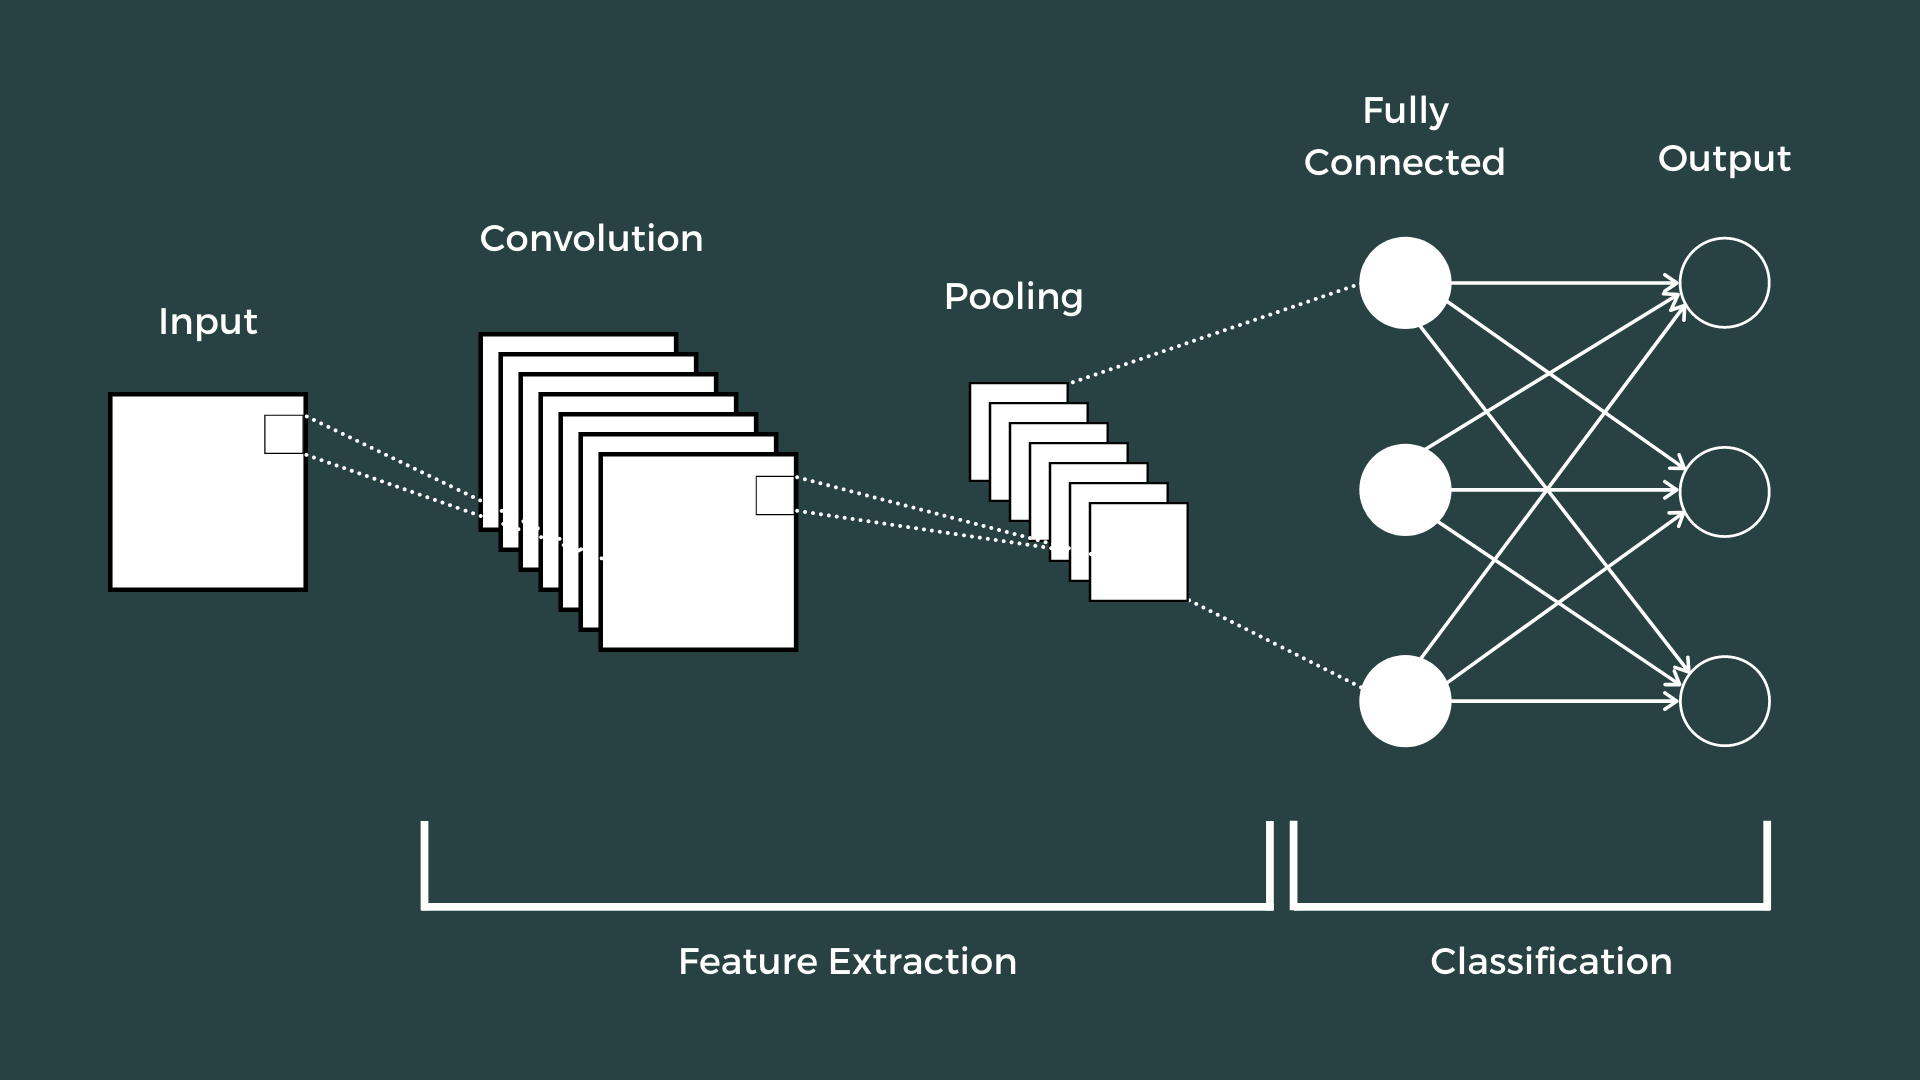

In [111]:
Image('../resources/cnn.png', width=700)
# https://www.theclickreader.com/introduction-to-convolutional-neural-networks/

#### We'll load the turbulence snapshot dataset to demonstrate

Vorticity field data has shape: (2000, 127, 127)
Reynolds number data has shape: (2000,)
Training data has shape: (2000, 16129)
Training labels have shape: (2000,)


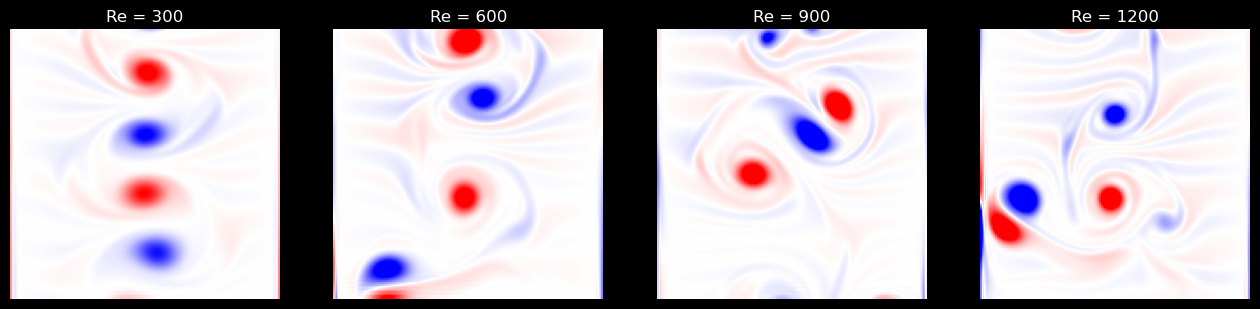

In [3]:
## load the turbulence dataset

all_vorticity_fields = list()
all_reynolds_numbers = list()

# Load simulations for different Reynolds numbers
re_vals = [300, 600, 900, 1200]
for re_val in re_vals:

    # Load the two-dimensional velocity field data. Data is stored in a 4D numpy array,
    # where the first dimension is the time index, the second and third dimensions are the
    # x and y coordinates, and the fourth dimension is the velocity components (ux or uv).
    vfield = np.load(
        f"../resources/von_karman_street/vortex_street_velocities_Re_{re_val}_largefile.npz", 
        allow_pickle=True
    )

    # Calculate the vorticity, which is the curl of the velocity field
    vort_field = np.diff(vfield, axis=1)[..., :-1, 1] + np.diff(vfield, axis=2)[:, :-1, :, 0]

    # Downsample the dataset
    vort_field = vort_field[::6, -127:, :]

    all_vorticity_fields.append(vort_field)
    all_reynolds_numbers.extend(re_val * np.ones(vort_field.shape[0]))

all_vorticity_fields = np.vstack(all_vorticity_fields)
all_reynolds_numbers = np.array(all_reynolds_numbers)

print("Vorticity field data has shape: {}".format(all_vorticity_fields.shape))
print("Reynolds number data has shape: {}".format(all_reynolds_numbers.shape))


## Plot some example snapshots of the vorticity field
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i, (ax, re_val) in enumerate(zip(axes, re_vals)):
    ax.imshow(all_vorticity_fields[all_reynolds_numbers == re_val][0], cmap='bwr', vmin=-0.01, vmax=0.01)
    ax.set_title(f"Re = {re_val}")
    ax.axis('off')

## Convert into a machine-learning dataset by flattening features

# Flatten the vorticity field data
X = np.reshape(all_vorticity_fields, (all_vorticity_fields.shape[0], -1))
y = all_reynolds_numbers

# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print("Training data has shape: {}".format(X.shape))
print("Training labels have shape: {}".format(y.shape))

### How many features does each input datapoint have?

In [4]:
print(all_vorticity_fields[0].shape)
print(X[0].shape)

(127, 127)
(16129,)


### How many trainable parameters would a fully-connected MLP have?



In [5]:

nh1 = 100
nh2 = 100
nh3 = 100

print(f"Total number of a parameters: {X.shape[1] * nh1 + nh1 * nh2 +nh2 * nh3}")
## Note: I'm not including bias terms in this calculation

Total number of a parameters: 1632900


## What do convolutional filters do?

Text(0.5, 1.0, 'Activation pattern of third filter')

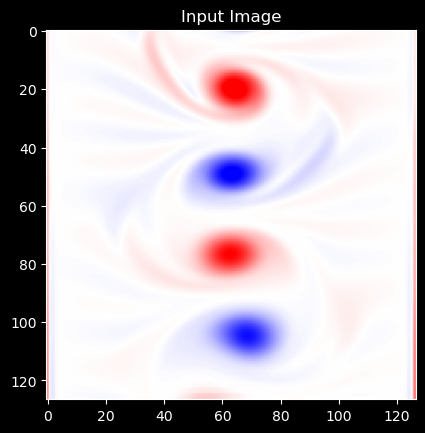

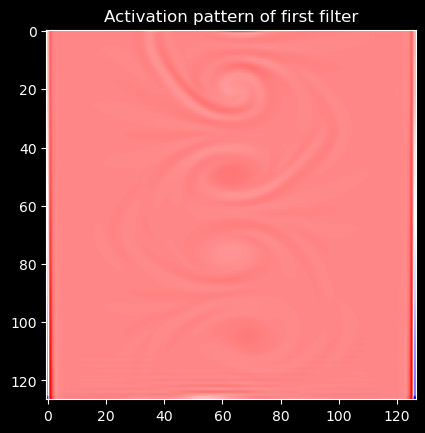

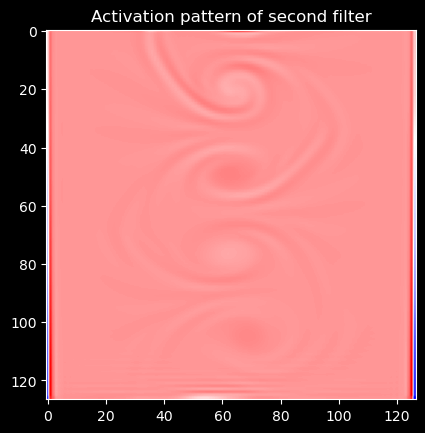

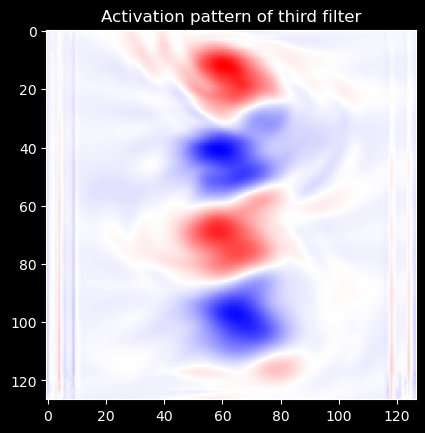

In [33]:

plt.figure()
plt.imshow(all_vorticity_fields[0], cmap='bwr', vmin=-0.01, vmax=0.01)
plt.title("Input Image")

## Define some possible convolutional filters
kernel1 = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
kernel2 = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]])
kernel3 = np.random.randn(20, 20)

import scipy.signal
h1 = scipy.signal.convolve2d(all_vorticity_fields[0], kernel1, mode='same')

plt.figure()
plt.imshow(h1, cmap='bwr')
plt.title("Activation pattern of first filter")

h2 = scipy.signal.convolve2d(all_vorticity_fields[0], kernel2, mode='same')

plt.figure()
plt.imshow(h2, cmap='bwr')
plt.title("Activation pattern of second filter")

h3 = scipy.signal.convolve2d(all_vorticity_fields[0], kernel3, mode='same')

plt.figure()
plt.imshow(h3, cmap='bwr')
plt.title("Activation pattern of third filter")



Text(0.5, 1.0, 'Activation pattern of third filter pooled')

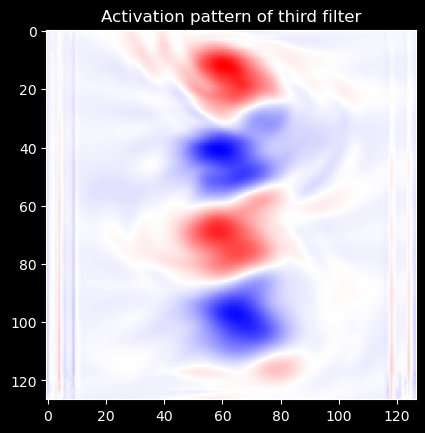

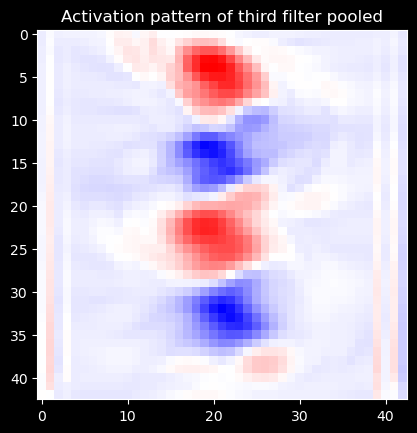

In [39]:
## Pool the filtered images

from scipy.ndimage.filters import maximum_filter

def max_pool(arr, n=3):
    """Pool an array by taking the maximum value of a sliding n x n window"""
    out = np.zeros_like(arr)
    for i in range(0, arr.shape[0], n):
        for j in range(0, arr.shape[1], n):
            out[i:i+n, j:j+n] = np.max(arr[i:i+n, j:j+n])

    out = out[::n, ::n]
    return out

h3_pool = max_pool(h3)

plt.figure()
plt.imshow(h3, cmap='bwr')
plt.title("Activation pattern of third filter")

plt.figure()
plt.imshow(h3_pool, cmap='bwr')
plt.title("Activation pattern of third filter pooled")

## Let's put it all together to see what these models might look like
    
+ We aren't yet discussing how to train these models, so we will just randomly initialize the weights and kernels

In [41]:
## We are not training our models; these have random weights

class MultilayerPercepton:

    def __init__(self, input_shape, output_shape, hidden_shapes=[100, 100]):
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.hidden_shapes = hidden_shapes
        self.layers = []
        for i, shape in enumerate(hidden_shapes):
            print(f"Hidden {i + 1} shape: ", (shape, input_shape))
            self.layers.append(np.random.randn(shape, input_shape))
            input_shape = shape
        print(f"Hidden {i + 2} shape: ", (output_shape, input_shape))
        self.layers.append(np.random.randn(output_shape, input_shape))

    def _sigma(self, x):
        """
        A tanh nonlinear activation function used in the neural network.
        """
        return np.tanh(x)

    def forward(self, x):
        for layer in self.layers:
            x = self._sigma(np.dot(layer, x))
        return x

            
model = MultilayerPercepton(X_train[0].shape[-1], 10, hidden_shapes=[100, 100])

model.forward(X_train[0])

Hidden 1 shape:  (100, 16129)
Hidden 2 shape:  (100, 100)
Hidden 3 shape:  (10, 100)


array([-0.99999998, -0.52595475, -0.99999941, -1.        , -0.99715747,
       -0.99999999, -0.69733068,  0.99999055, -0.99396775,  1.        ])

In [42]:
class ConvolutionalNeuralNetwork:
    """
    A convolutional neural network with 1 convolutional layer, 1 pooling layer, and 
    arbitrary hidden layers.
    """

    def __init__(self, input_shape, output_shape, pool_size=10, hidden_shapes=[100, 100]):
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.hidden_shapes = hidden_shapes
        self.pool_size = pool_size

        self.kernel = np.random.randn(3,)
        print(f"Conv1 shape: ", self.kernel.shape)
        input_shape = (input_shape - self.kernel.shape[-1] + 1) // self.pool_size
        
        self.layers = []
        for i, shape in enumerate(hidden_shapes):
            print(f"Hidden {i + 1} shape: ", (shape, input_shape))
            self.layers.append(np.random.randn(shape, input_shape))
            input_shape = shape
        print(f"Hidden {i + 2} shape: ", (output_shape, input_shape))
        self.layers.append(np.random.randn(output_shape, input_shape))

    def _sigma(self, x):
        """
        A ReLU nonlinear activation function used in the neural network.
        """
        out = x
        out[out < 0] = 0
        return out

    def forward(self, x):

        # Convolution
        x = self._sigma(np.convolve(x, self.kernel, mode='same'))

        # Max-Pooling
        # take the max value of each 3x1 block
        all_clumps = [x[i::self.pool_size] for i in range(self.pool_size)]
        min_len = min([len(clump) for clump in all_clumps])
        all_clumps = np.array([clump[:min_len] for clump in all_clumps])
        x = all_clumps.max(axis=0)

        for layer in self.layers:
            x = self._sigma(np.dot(layer, x))
        return x

model = ConvolutionalNeuralNetwork(X_train[0].shape[-1], 10, hidden_shapes=[100, 100])

model.forward(X_train[0])

Conv1 shape:  (3,)
Hidden 1 shape:  (100, 1612)
Hidden 2 shape:  (100, 100)
Hidden 3 shape:  (10, 100)


array([0.        , 0.16714396, 0.        , 0.        , 0.4024182 ,
       0.        , 0.81681566, 0.45454396, 0.        , 1.08882927])

## Residual networks

+ Residual networks are a special case of a neural network with skip connections
+ These skip connections make it a little easier to train deeper networks, but avoiding "vanishing gradients" an issue with gradient descent for deep networks
+ We'll discuss training DNNs in more detail later

$$
\mathbf{h}_t = \sigma(\mathbf{W}_t \mathbf{h}_{t-1}) + \mathbf{h}_{t-1}
$$

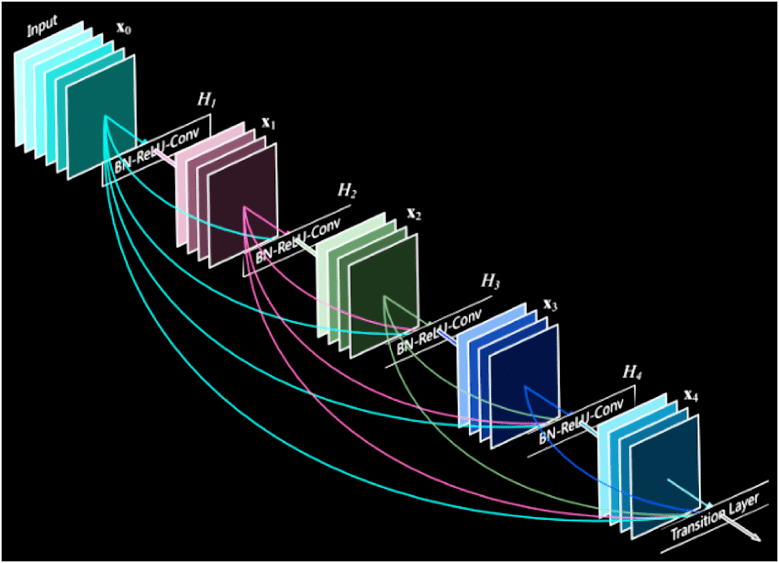

In [46]:
Image('../resources/residual.png', width=700)
# https://datascience.eu/machine-learning/an-overview-of-resnet-and-its-variants/

# Recurrent neural networks

+ Neural networks for sequential data (time series, text, etc)
+ Each layer is a function of the previous layer and the current input. The network has a trainable internal transition matrix, which is iterated several times. The state depends on the previous state and the current input

$$
\mathbf{h}_t = \sigma(\mathbf{W}_h \mathbf{h}_{t-1} + \mathbf{W}_x \mathbf{x}_t)
$$

$$
\mathbf{y}_t = \sigma(\mathbf{W}_y \mathbf{h}_t)
$$

Compare to a multilayer perceptron: takes a single input, propagates across several hidden layers with different weight matrices, and then returns a single output
$$
\mathbf{h}_t = \sigma(\mathbf{W}_t \mathbf{h}_{t-1})
$$

$$
\mathbf{y}_t = \mathbf{h}_t
$$


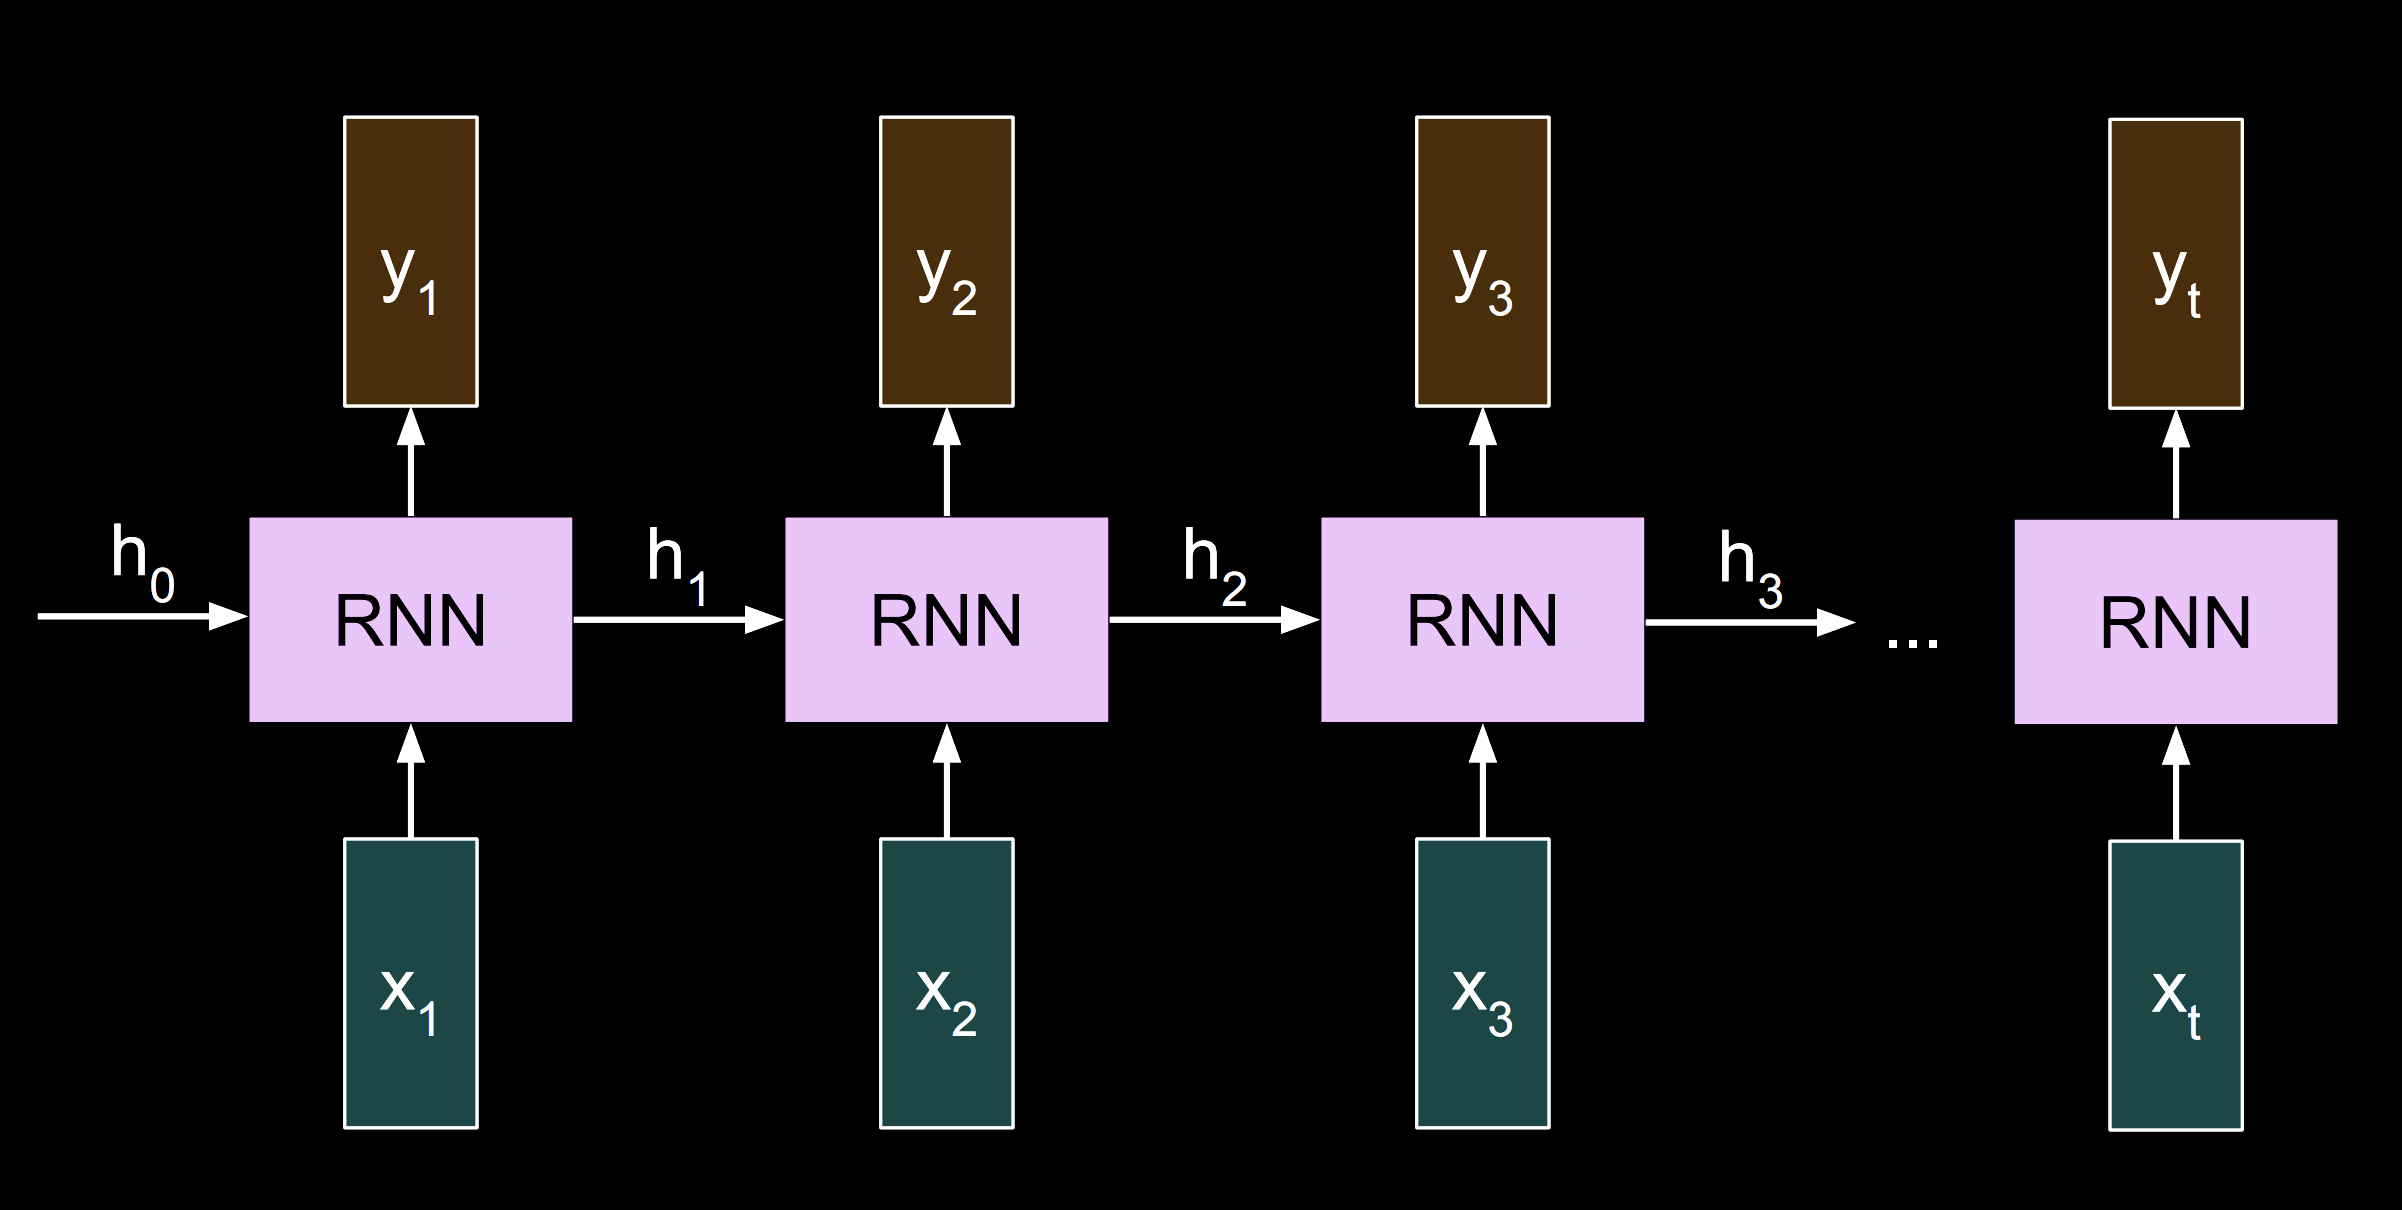

In [135]:
Image('../resources/rnn.png', width=700)
# http://cs231n.stanford.edu/slides/2021/lecture_10.pdf

# Autoencoders

+ Neural networks for unsupervised representation learning

Encoder:
$$
\mathbf{z} = \mathbf{f}(\mathbf{x})
$$

Decoder:
$$
\hat{\mathbf{x}} = \mathbf{g}(\mathbf{z})
$$

Both $\mathbf{f}$ and $\mathbf{g}$ are neural networks (perceptions, etc)

+ The encoder and decoder are trained to minimize the reconstruction error

$$
\mathcal{L} = \frac{1}{N} \sum_{i=1}^N \left\| \mathbf{x}_i - \hat{\mathbf{x}}_i \right\|_2^2
$$

+ By putting constraints on the *latent space* (the space of the encoded data), we can reduce dimensionality (ala PCA) or enforce certain symmetries (e.g. invariance to rotations)


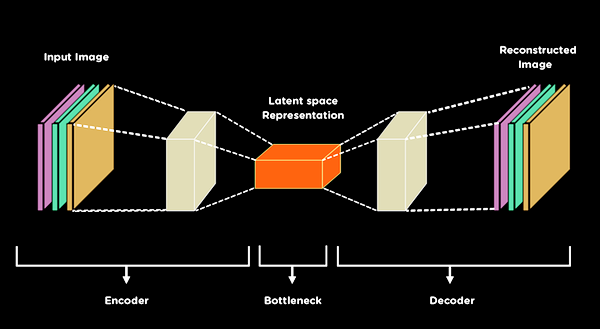

In [45]:
Image('../resources/ae2.png', width=800)
# https://medium.com/@birla.deepak26/autoencoders-76bb49ae6a8f

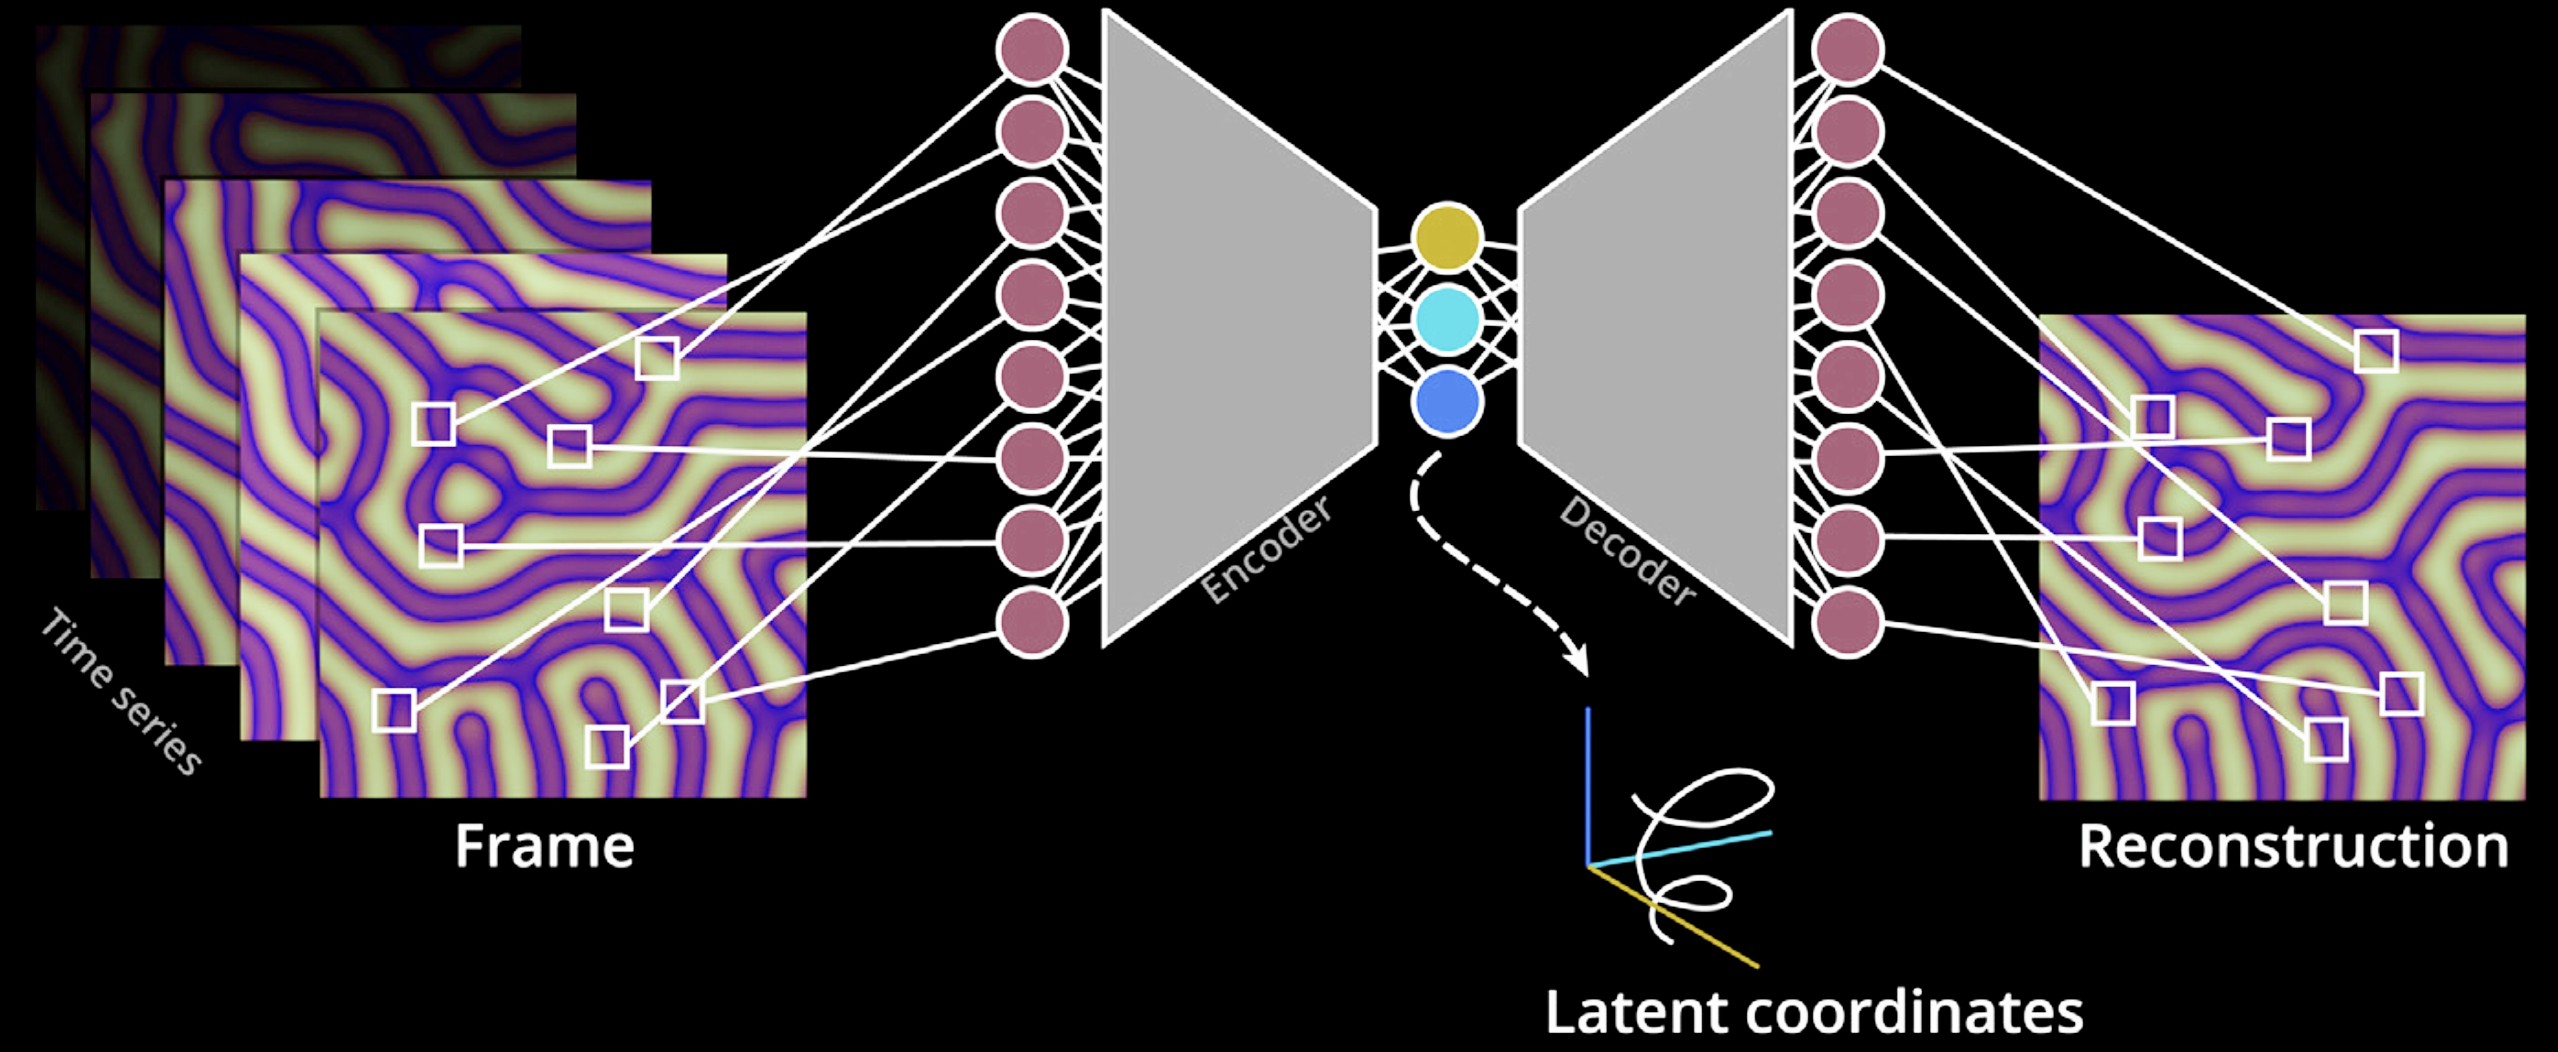

In [44]:
Image('../resources/ae.png', width=800)
# Gilpin et al 2019, https://www.sciencedirect.com/science/article/abs/pii/S2452310020300147

# What else is out there?

+ *Anything* that takes a vector and returns a vector can be a neural network
+ The hard part is finding a way to train it, ideally using gradient descent

### Transformers

+ Replacing RNNs for large sequential datasets
+ Attention mechanism: each layer attends to a different part of the input

### Variational autoencoders (and generative models in general)

+ Input vectors are sampled from some unknonwn distribution
+ Learn a latent probability distribution, can sample the distribution to generate new datapoints similar to the training data

### Neural ODEs

+ Instead of having "Layers," train a continuous-time ODE that maps an input vector to an output vector

### Diffusion models

+ Generative models that assume that training data is sampled from some distribution
+ Simulate forward/backwards Kolmogorov equations to generate new datapoints



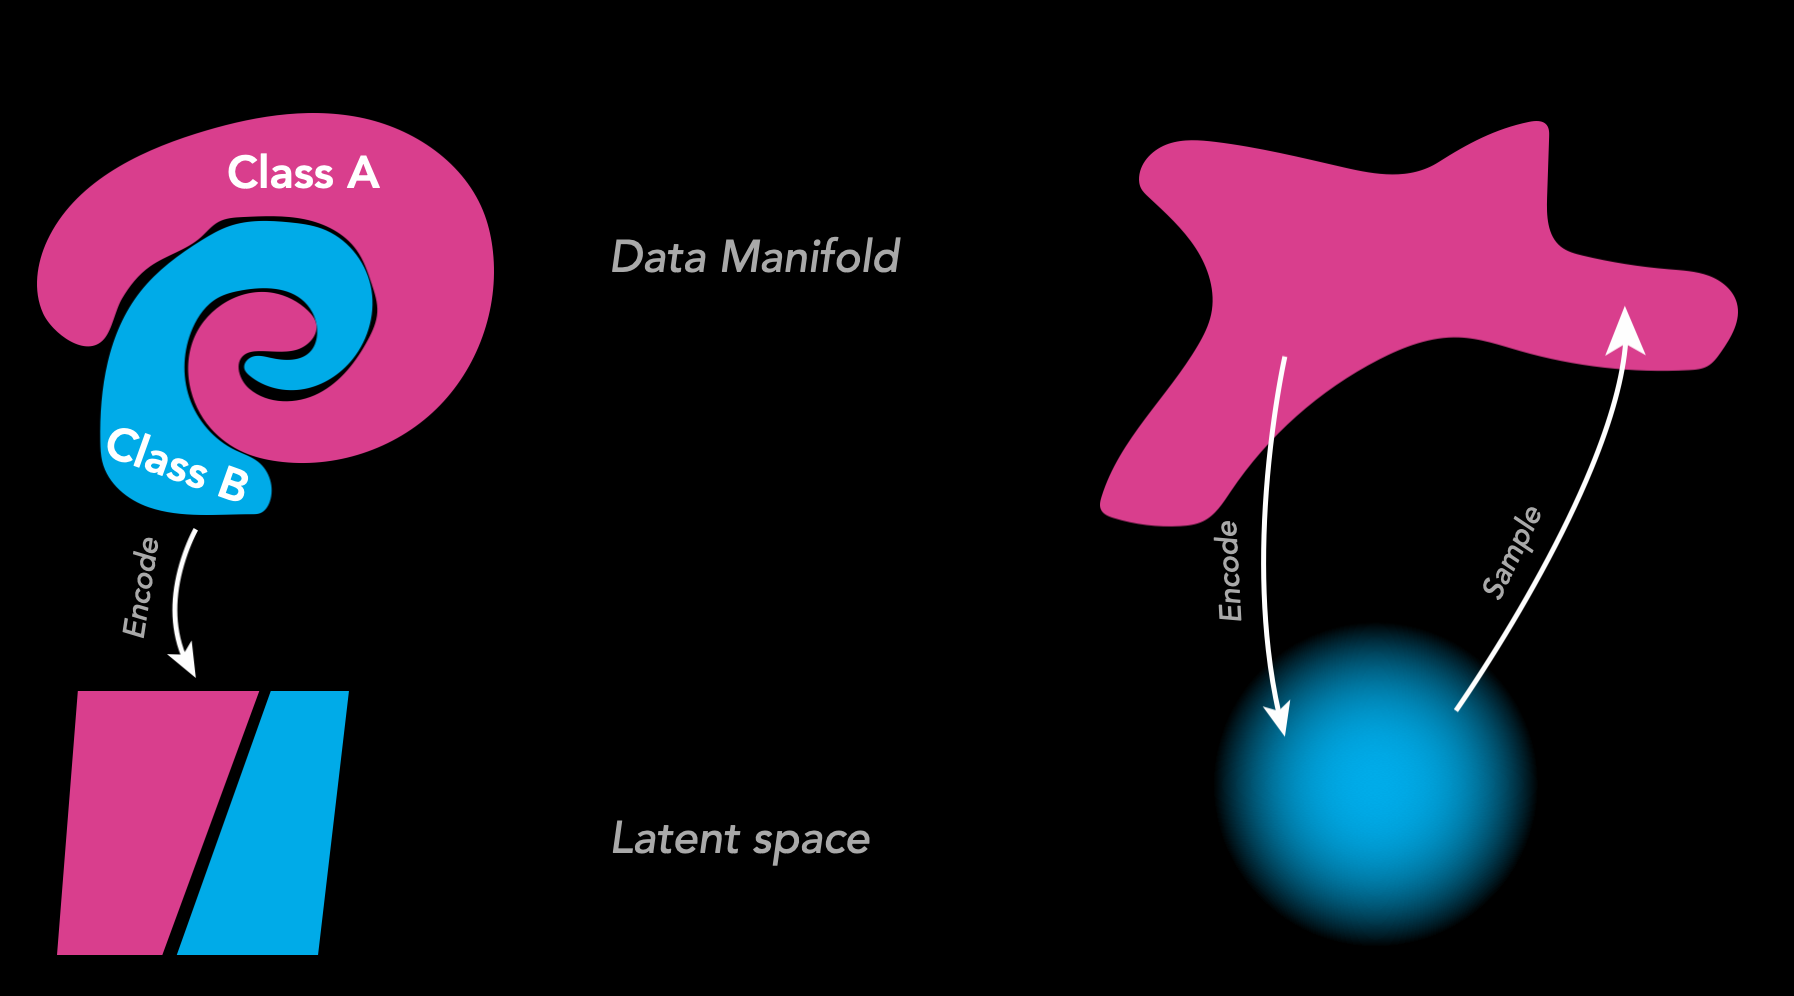

In [3]:
Image('../resources/representations.png', width=800)